In [44]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from time import time
import matplotlib.colors as colors
import sys
from minimum_energy import Disambiguator

In [45]:
nsnaps = 163
nx = 384
ny = 384
snapshot = 50

Bx_tau01 = np.memmap('layers_downsampled/tau_0.100_bx.dat', dtype=np.float32, mode='r', shape=(nsnaps, nx, ny))
By_tau01 = np.memmap('layers_downsampled/tau_0.100_by.dat', dtype=np.float32, mode='r', shape=(nsnaps, nx, ny))
Bz_tau01 = np.memmap('layers_downsampled/tau_0.100_bz.dat', dtype=np.float32, mode='r', shape=(nsnaps, nx, ny))

Bx_true = Bx_tau01[snapshot].copy().astype(np.float64)[::3,::3]
By_true = By_tau01[snapshot].copy().astype(np.float64)[::3,::3]
Bz_true = Bz_tau01[snapshot].copy().astype(np.float64)[::3,::3]
Bz_true.shape

(128, 128)

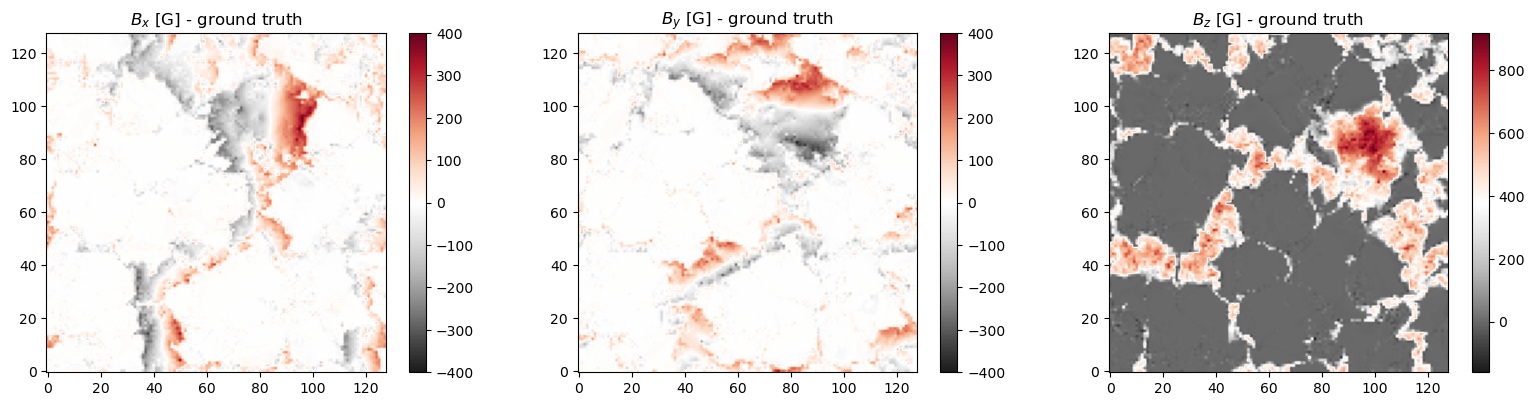

In [46]:
plt.figure(figsize=(16, 4))
plt.subplot(131)
plt.imshow(Bx_true.T, origin='lower', cmap='RdGy_r', vmin=-400, vmax=400)
plt.title(r'$B_x$ [G] - ground truth')
plt.colorbar()
plt.subplot(132)
plt.imshow(By_true.T, origin='lower', cmap='RdGy_r', vmin=-400, vmax=400)
plt.title(r'$B_y$ [G] - ground truth')
plt.colorbar()
plt.subplot(133)
plt.imshow(Bz_true, origin='lower', cmap='RdGy_r')
plt.title(r'$B_z$ [G] - ground truth')
plt.colorbar()
plt.tight_layout()
plt.show()

In [47]:
ll = np.linspace(6301, 6303, 201) 
l0 = 6301.5
sigma = 0.06

I_profile = 1.0 - 0.7 * np.exp(-(ll - l0)**2 / (2*sigma**2))

ny, nx = Bx_true.shape
I_stokes = np.tile(I_profile, (ny, nx, 1))

def synthesize_stokes_V_wfa_numpy(Bz, I_profile, ll, g_eff=1.67, lambda0=6301.5):
    ny, nx, n_lambda = I_profile.shape
    
    dll = ll[1] - ll[0]
    dI_dl = np.gradient(I_profile, axis=2) / dll
    
    C = 4.67e-13
    lambda_sq = lambda0**2
    Bz_expanded = Bz[:, :, np.newaxis]
    V_synth = -C * dI_dl * lambda_sq * g_eff * Bz_expanded
    
    return V_synth

def synthesize_stokes_QU_wfa_numpy(Bx, By, I_profile, ll, scale_factor=1e-4):
    ny, nx, n_lambda = I_profile.shape
    
    dll = ll[1] - ll[0]
    dI_dl = np.gradient(I_profile, axis=2) / dll
    
    Bx_expanded = Bx[:, :, np.newaxis]
    By_expanded = By[:, :, np.newaxis]
    
    BT_sq = Bx_expanded**2 + By_expanded**2
    P_synth = scale_factor * dI_dl**2 * BT_sq
    
    chi = np.arctan2(By_expanded, Bx_expanded)
    Q_synth = P_synth * np.sin(2 * chi)
    U_synth = P_synth * np.cos(2 * chi)
    
    return Q_synth, U_synth

V_gt = synthesize_stokes_V_wfa_numpy(Bz_true, I_stokes, ll)
Q_gt, U_gt = synthesize_stokes_QU_wfa_numpy(Bx_true, By_true, I_stokes, ll, scale_factor=1e-8)


print(f"V range: [{V_gt.min():.3e}, {V_gt.max():.3e}]")
print(f"Q range: [{Q_gt.min():.3e}, {Q_gt.max():.3e}]")
print(f"U range: [{U_gt.min():.3e}, {U_gt.max():.3e}]")

V range: [-1.994e-01, 1.994e-01]
Q range: [-7.361e-02, 5.977e-02]
U range: [-7.389e-02, 6.692e-02]


In [49]:
line_core_start = 35 
line_core_end = 65
ll_core = ll[line_core_start:line_core_end]  

I_core = I_stokes[:, :, line_core_start:line_core_end]  
V_core = V_gt[:, :, line_core_start:line_core_end]
Q_core = Q_gt[:, :, line_core_start:line_core_end]
U_core = U_gt[:, :, line_core_start:line_core_end]

stokes = np.stack([I_core, Q_core, U_core, V_core], axis=2)

In [50]:
device = torch.device('cpu')

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.enc1 = self.conv_block(in_channels, 16)
        self.enc2 = self.conv_block(16, 32)
        self.pool = nn.MaxPool2d(2)
        
        self.bottleneck = self.conv_block(32, 64)
        
        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = self.conv_block(64, 32)
        self.up2 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.dec2 = self.conv_block(32, 16)
        
        self.out = nn.Conv2d(16, out_channels, 1)
    
    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU())
    
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        
        b = self.bottleneck(self.pool(e2))
        
        d1 = self.up1(b)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)
        
        d2 = self.up2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        
        return self.out(d2)

In [51]:
def synthesize_stokes_V_wfa(Bz, I_profile, ll, g_eff=1.67, lambda0=6301.5):
    batch, ny, nx, n_lambda = I_profile.shape
    
    dll = ll[1] - ll[0]
    dI_dl = torch.gradient(I_profile, dim=3)[0] / dll
    
    C = 4.67e-13
    lambda_sq = lambda0**2
    Bz_expanded = Bz.unsqueeze(-1).expand(-1, -1, -1, n_lambda)
    V_synth = -C * dI_dl * lambda_sq * g_eff * Bz_expanded
    
    return V_synth

def synthesize_stokes_QU_wfa(Bx, By, I_profile, ll, scale_factor=1e-8):
    batch, ny, nx, n_lambda = I_profile.shape
    
    dll = ll[1] - ll[0]
    dI_dl = torch.gradient(I_profile, dim=3)[0] / dll
    
    Bx_expanded = Bx.unsqueeze(-1).expand(-1, -1, -1, n_lambda)
    By_expanded = By.unsqueeze(-1).expand(-1, -1, -1, n_lambda)
    
    BT_sq = Bx_expanded**2 + By_expanded**2
    P_synth = scale_factor * dI_dl**2 * BT_sq
    
    chi = torch.atan2(By_expanded, Bx_expanded)
    Q_synth = P_synth * torch.sin(2 * chi)
    U_synth = P_synth * torch.cos(2 * chi)
    
    return Q_synth, U_synth
    

In [52]:
def physics_loss(B_pred, stokes_obs, ll, alpha=1.0, beta=1.0, gamma=1.0, dx=1.0, dy=1.0):
    
    Bx_pred = B_pred[:, 0, :, :]
    By_pred = B_pred[:, 1, :, :]
    Bz_pred = B_pred[:, 2, :, :]
    
    I_obs = stokes_obs[:, :, :, 0, :]
    Q_obs = stokes_obs[:, :, :, 1, :]
    U_obs = stokes_obs[:, :, :, 2, :]
    V_obs = stokes_obs[:, :, :, 3, :]
    
    V_synth = synthesize_stokes_V_wfa(Bz_pred, I_obs, ll)
    Q_synth, U_synth = synthesize_stokes_QU_wfa(Bx_pred, By_pred, I_obs, ll, scale_factor=1e-8)
    V_std = torch.std(V_obs) + 1e-10
    Q_std = torch.std(Q_obs) + 1e-10
    U_std = torch.std(U_obs) + 1e-10
    
    residual_V = (V_obs - V_synth) / V_std
    residual_Q = (Q_obs - Q_synth) / Q_std
    residual_U = (U_obs - U_synth) / U_std
    
    loss_V = torch.mean(residual_V**2)
    loss_Q = torch.mean(residual_Q**2)
    loss_U = torch.mean(residual_U**2)

    total_loss = alpha * loss_V + beta * loss_Q + gamma * loss_U
    
    return total_loss, loss_V, loss_Q, loss_U

In [69]:
stokes_core = stokes
n_wavelengths_core = len(ll_core)
in_channels = 4 * n_wavelengths_core
out_channels = 3

model = UNet(in_channels, out_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5)

ll_tensor = torch.tensor(ll_core, dtype=torch.float32, device=device)

stokes_torch = torch.from_numpy(stokes_core.astype(np.float32)).to(device)
stokes_torch = stokes_torch.unsqueeze(0)

ny, nx = stokes_core.shape[0], stokes_core.shape[1]
stokes_input = stokes_torch.permute(0, 3, 4, 1, 2)
stokes_input = stokes_input.reshape(1, -1, ny, nx)

print(f"Input channels: {in_channels}")
print(f"Output channels: {out_channels}")
print(f"Wavelength range: {n_wavelengths_core} points")
print(f"V observed range: [{stokes_core[:,:,3,:].min():.3e}, {stokes_core[:,:,3,:].max():.3e}]")
print(f"Q observed range: [{stokes_core[:,:,1,:].min():.3e}, {stokes_core[:,:,1,:].max():.3e}]")
print(f"U observed range: [{stokes_core[:,:,2,:].min():.3e}, {stokes_core[:,:,2,:].max():.3e}]")

Input channels: 120
Output channels: 3
Wavelength range: 30 points
V observed range: [-1.994e-01, 1.994e-01]
Q observed range: [-7.361e-02, 5.977e-02]
U observed range: [-7.389e-02, 6.692e-02]


In [70]:
start = time()
alpha, beta, gamma = 1.0, 1.0, 1.0
n_epochs = 1000
loss_history = []
loss_V_history = []
loss_Q_history = []
loss_U_history = []

best_loss = float('inf')
patience_counter = 0
early_stop_patience = 100

for epoch in tqdm(range(n_epochs), desc="Training"):
    optimizer.zero_grad()
    
    B_pred = model(stokes_input)
    loss, loss_V, loss_Q, loss_U = physics_loss(
    B_pred, stokes_torch, ll_tensor)

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step(loss)
    
    loss_history.append(loss.item())
    loss_V_history.append(loss_V.item())
    loss_Q_history.append(loss_Q.item())
    loss_U_history.append(loss_U.item())

    if loss.item() < best_loss - 1e-4:
        best_loss = loss.item()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch}")
        break

    if epoch % 100 == 0:
        Bx_range = B_pred[0, 0, :, :].detach()
        By_range = B_pred[0, 1, :, :].detach()
        Bz_range = B_pred[0, 2, :, :].detach()
       
        tqdm.write(f"Epoch {epoch}, Loss: {loss.item():.6e}, V: {loss_V.item():.6e}, Q: {loss_Q.item():.6e}, U: {loss_U.item():.6e}")
        tqdm.write(f"  Bx: [{Bx_range.min():.1f}, {Bx_range.max():.1f}], By: [{By_range.min():.1f}, {By_range.max():.1f}], Bz: [{Bz_range.min():.1f}, {Bz_range.max():.1f}]")

end = time()
print(f"Procedure lasted for {end - start:.2f} seconds")

Training:   0%|          | 1/1000 [00:00<06:51,  2.43it/s]

Epoch 0, Loss: 3.000090e+00, V: 9.999072e-01, Q: 9.999992e-01, U: 1.000183e+00
  Bx: [-0.2, -0.2], By: [0.0, 0.0], Bz: [0.0, 0.0]


Training:  10%|█         | 101/1000 [00:36<05:35,  2.68it/s]

Epoch 100, Loss: 1.355420e+00, V: 1.382566e-01, Q: 6.795018e-01, U: 5.376611e-01
  Bx: [-343.1, 59.5], By: [-216.3, 278.4], Bz: [-24.9, 1028.2]


Training:  20%|██        | 201/1000 [01:01<02:46,  4.79it/s]

Epoch 200, Loss: 7.882143e-01, V: 9.908278e-02, Q: 3.401594e-01, U: 3.489722e-01
  Bx: [-343.1, 191.7], By: [-262.0, 297.9], Bz: [-49.1, 872.6]


Training:  30%|███       | 301/1000 [01:29<04:25,  2.63it/s]

Epoch 300, Loss: 5.981208e-01, V: 8.416643e-02, Q: 2.569107e-01, U: 2.570437e-01
  Bx: [-378.2, 227.8], By: [-286.1, 338.3], Bz: [-92.1, 866.4]


Training:  40%|████      | 401/1000 [02:00<03:23,  2.94it/s]

Epoch 400, Loss: 4.442558e-01, V: 7.385681e-02, Q: 1.870143e-01, U: 1.833847e-01
  Bx: [-373.2, 207.5], By: [-282.3, 342.2], Bz: [-77.8, 827.0]


Training:  50%|█████     | 501/1000 [02:27<01:41,  4.91it/s]

Epoch 500, Loss: 3.649317e-01, V: 6.904540e-02, Q: 1.514526e-01, U: 1.444336e-01
  Bx: [-364.5, 222.3], By: [-311.9, 343.5], Bz: [-96.8, 824.8]


Training:  60%|██████    | 601/1000 [02:46<01:20,  4.94it/s]

Epoch 600, Loss: 3.425045e-01, V: 6.218178e-02, Q: 1.458513e-01, U: 1.344714e-01
  Bx: [-364.5, 244.4], By: [-293.3, 352.2], Bz: [-75.5, 836.9]


Training:  70%|███████   | 701/1000 [03:05<00:57,  5.22it/s]

Epoch 700, Loss: 2.410360e-01, V: 5.584428e-02, Q: 9.617897e-02, U: 8.901273e-02
  Bx: [-370.7, 254.9], By: [-307.3, 368.0], Bz: [-89.8, 838.8]


Training:  80%|████████  | 801/1000 [03:24<00:38,  5.14it/s]

Epoch 800, Loss: 2.059521e-01, V: 5.199768e-02, Q: 8.003818e-02, U: 7.391620e-02
  Bx: [-396.3, 258.0], By: [-314.9, 388.1], Bz: [-96.0, 845.1]


Training:  90%|█████████ | 901/1000 [03:43<00:18,  5.29it/s]

Epoch 900, Loss: 2.124791e-01, V: 4.957630e-02, Q: 8.332269e-02, U: 7.958007e-02
  Bx: [-353.9, 275.4], By: [-306.0, 373.0], Bz: [-77.6, 860.7]


Training: 100%|██████████| 1000/1000 [04:02<00:00,  4.13it/s]

Procedure lasted for 242.11 seconds


In [71]:
Bx_pred = B_pred[0, 0, :, :].unsqueeze(0)  
By_pred = B_pred[0, 1, :, :].unsqueeze(0)  
Bz_pred = B_pred[0, 2, :, :].unsqueeze(0) 

I_obs_torch = stokes_torch[:, :, :, 0, :]  

V_synth = synthesize_stokes_V_wfa(Bz_pred, I_obs_torch, ll_tensor)
Q_synth, U_synth = synthesize_stokes_QU_wfa(Bx_pred, By_pred, I_obs_torch, ll_tensor, scale_factor=1e-8)

Bx_pred = Bx_pred[0].detach().cpu().numpy() 
By_pred = By_pred[0].detach().cpu().numpy()
Bz_pred = Bz_pred[0].detach().cpu().numpy()

V_pred = V_synth[0, :, :, :].detach().cpu().numpy()
Q_pred = Q_synth[0, :, :, :].detach().cpu().numpy()
U_pred = U_synth[0, :, :, :].detach().cpu().numpy()

V_obs = stokes_torch[0, :, :, 3, :].detach().cpu().numpy()
Q_obs = stokes_torch[0, :, :, 1, :].detach().cpu().numpy()
U_obs = stokes_torch[0, :, :, 2, :].detach().cpu().numpy()

print(f"\nGround truth Bx range: [{Bx_true.min():.1f}, {Bx_true.max():.1f}] G")
print(f"Ground truth By range: [{By_true.min():.1f}, {By_true.max():.1f}] G")
print(f"Ground truth Bz range: [{Bz_true.min():.1f}, {Bz_true.max():.1f}] G")
print(f"\nFinal Bx range: [{Bx_pred.min():.1f}, {Bx_pred.max():.1f}] G")
print(f"Final By range: [{By_pred.min():.1f}, {By_pred.max():.1f}] G")
print(f"Final Bz range: [{Bz_pred.min():.1f}, {Bz_pred.max():.1f}] G")


Ground truth Bx range: [-332.3, 392.9] G
Ground truth By range: [-388.7, 323.7] G
Ground truth Bz range: [-160.6, 918.3] G

Final Bx range: [-385.1, 260.3] G
Final By range: [-321.3, 364.1] G
Final Bz range: [-115.6, 852.6] G


In [72]:
cc_Bx = np.corrcoef(Bx_true.flatten(), Bx_pred.flatten())[0][1]
cc_By = np.corrcoef(By_true.flatten(), By_pred.flatten())[0][1]
cc_Bz = np.corrcoef(Bz_true.flatten(), Bz_pred.flatten())[0][1]
print(f"Bx correlation: {cc_Bx:.3f}, By correlation: {cc_By:.3f}, Bz correlation: {cc_Bz:.3f}")

cc_V = np.corrcoef(V_obs.flatten(), V_pred.flatten())[0][1]
cc_Q = np.corrcoef(Q_obs.flatten(), Q_pred.flatten())[0][1]
cc_U = np.corrcoef(U_obs.flatten(), U_pred.flatten())[0][1]
print(f"V correlation: {cc_V:.3f}, Q correlation: {cc_Q:.3f}, U correlation: {cc_U:.3f}")

Bt_pred = np.sqrt(Bx_pred**2 + By_pred**2)
Bt_true = np.sqrt(Bx_true**2 + By_true**2)

print(f"B transverse magnitude correlation: {np.corrcoef(Bt_pred.flat, Bt_true.flat)[0,1]:.3f}")

Bx correlation: -0.396, By correlation: -0.641, Bz correlation: 0.968
V correlation: 0.977, Q correlation: 0.962, U correlation: 0.962
B transverse magnitude correlation: 0.954


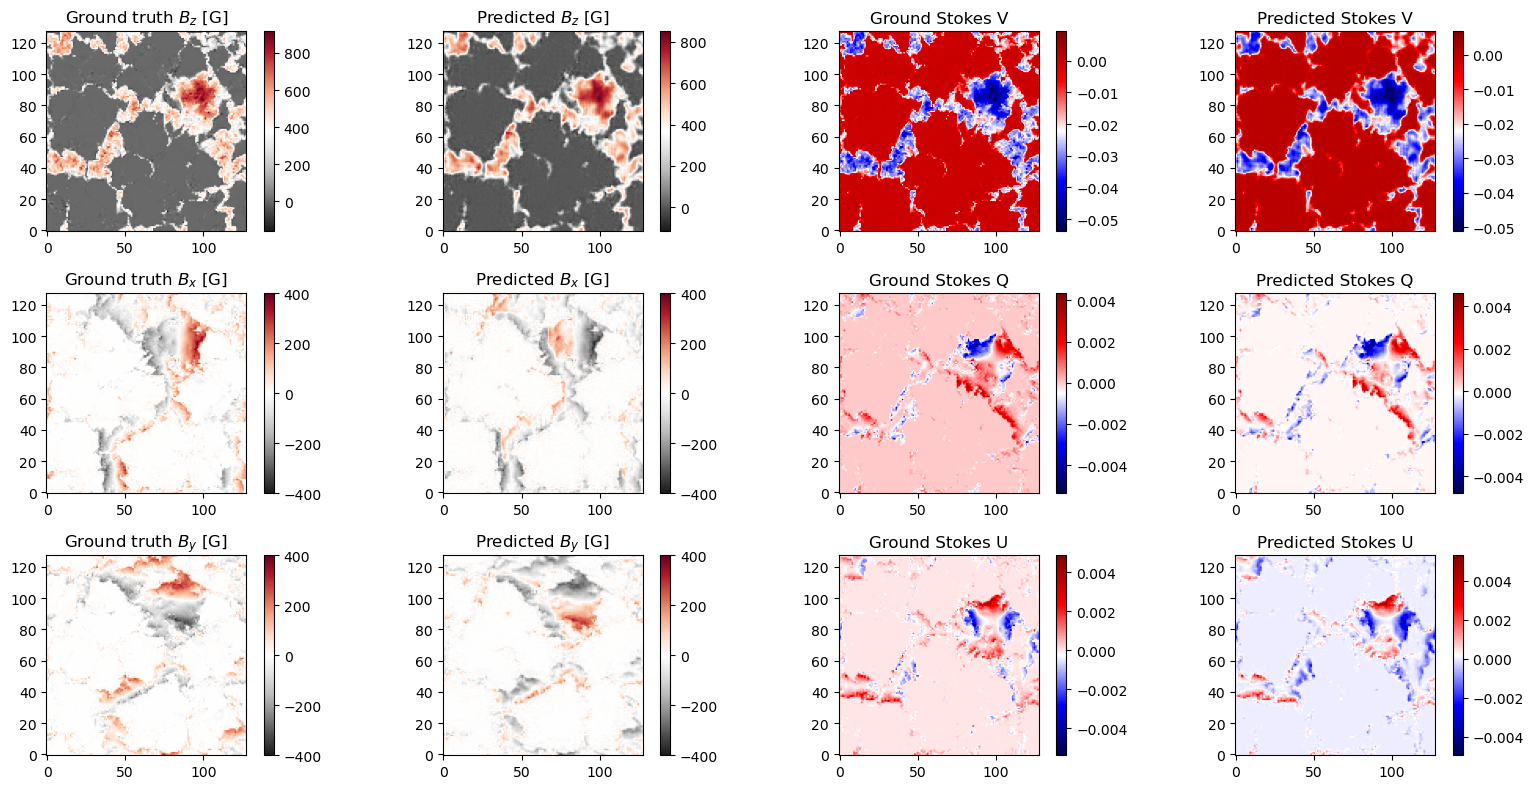

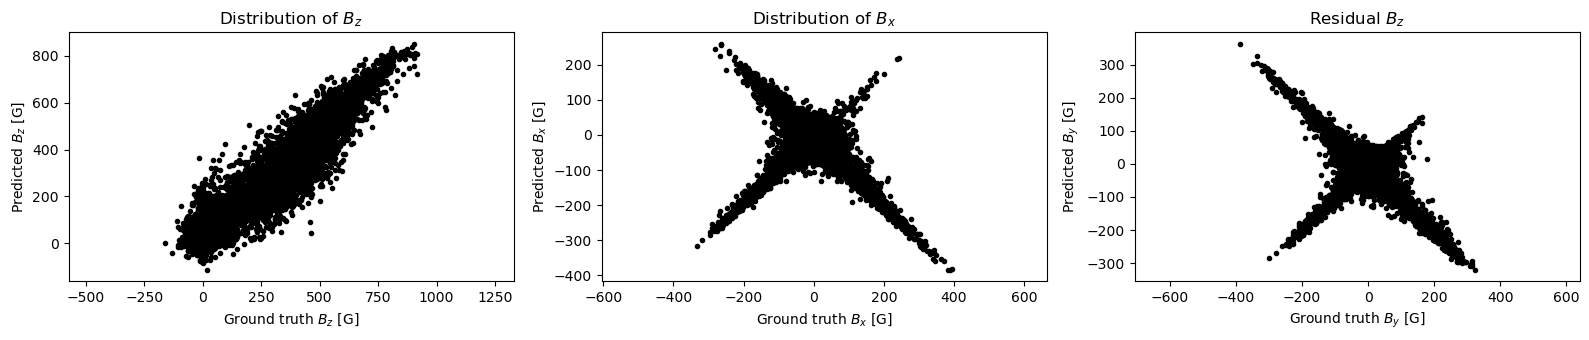

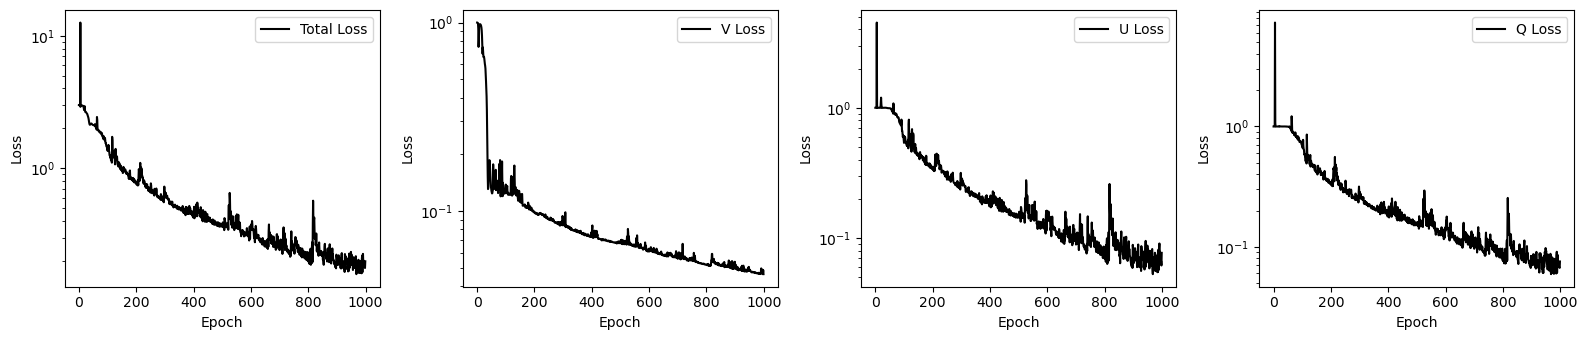

In [73]:
plt.figure(figsize=(16, 8))
plt.subplot(341)
plt.imshow(Bz_true, origin='lower', cmap='RdGy_r')
plt.colorbar()
plt.title(r'Ground truth $B_z$ [G]')
plt.subplot(342)
plt.imshow(Bz_pred, origin='lower', cmap='RdGy_r')
plt.colorbar()
plt.title(r'Predicted $B_z$ [G]')
plt.subplot(343)
plt.imshow(V_obs[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Ground Stokes V')
plt.subplot(344)
plt.imshow(V_pred[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Predicted Stokes V')
plt.subplot(345)
plt.imshow(Bx_true.T, origin='lower', cmap='RdGy_r', vmin=-400, vmax=400)
plt.colorbar()
plt.title(r'Ground truth $B_x$ [G]')
plt.subplot(346)
plt.imshow(Bx_pred.T, origin='lower', cmap='RdGy_r',vmin=-400, vmax=400)
plt.colorbar()
plt.title(r'Predicted $B_x$ [G]')
plt.subplot(347)
plt.imshow(Q_obs[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Ground Stokes Q')
plt.subplot(348)
plt.imshow(Q_pred[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Predicted Stokes Q')
plt.subplot(349)
plt.imshow(By_true.T, origin='lower', cmap='RdGy_r', vmin=-400, vmax=400)
plt.colorbar()
plt.title(r'Ground truth $B_y$ [G]')
plt.subplot(3,4,10)
plt.imshow(By_pred.T, origin='lower', cmap='RdGy_r', vmin=-400, vmax=400)
plt.colorbar()
plt.title(r'Predicted $B_y$ [G]')
plt.subplot(3,4,11)
plt.imshow(U_obs[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Ground Stokes U')
plt.subplot(3,4,12)
plt.imshow(U_pred[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Predicted Stokes U')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 3.5))
plt.subplot(131)
plt.plot(Bz_true.flatten(), Bz_pred.flatten(), 'k.')
plt.title('Distribution of $B_z$')
plt.xlabel('Ground truth $B_z$ [G]')
plt.ylabel('Predicted $B_z$ [G]')
plt.axis('equal')
plt.subplot(132)
plt.plot(Bx_true.flatten(), Bx_pred.flatten(), 'k.')
plt.title('Distribution of $B_x$')
plt.xlabel('Ground truth $B_x$ [G]')
plt.ylabel('Predicted $B_x$ [G]')
plt.axis('equal')
plt.subplot(133)
plt.plot(By_true.flatten(), By_pred.flatten(), 'k.')
plt.title('Distribution of $B_y$')
plt.xlabel('Ground truth $B_y$ [G]')
plt.ylabel('Predicted $B_y$ [G]')
plt.axis('equal')
plt.title(r'Residual $B_z$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,3.5))
plt.subplot(141)
plt.semilogy(loss_history, label='Total Loss', color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(142)
plt.semilogy(loss_V_history, label='V Loss', color='black')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.legend()
plt.subplot(143)
plt.semilogy(loss_U_history, label='U Loss', color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(144)
plt.semilogy(loss_Q_history, label='Q Loss', color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [58]:
stokes_core = stokes
n_wavelengths_core = len(ll_core)
in_channels = 4 * n_wavelengths_core
out_channels = 3

model = UNet(in_channels, out_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5)

ll_tensor = torch.tensor(ll_core, dtype=torch.float32, device=device)

stokes_torch = torch.from_numpy(stokes_core.astype(np.float32)).to(device)
stokes_torch = stokes_torch.unsqueeze(0)

ny, nx = stokes_core.shape[0], stokes_core.shape[1]
stokes_input = stokes_torch.permute(0, 3, 4, 1, 2)
stokes_input = stokes_input.reshape(1, -1, ny, nx)

print(f"Input channels: {in_channels}")
print(f"Output channels: {out_channels}")
print(f"Wavelength range: {n_wavelengths_core} points")
print(f"V observed range: [{stokes_core[:,:,3,:].min():.3e}, {stokes_core[:,:,3,:].max():.3e}]")
print(f"Q observed range: [{stokes_core[:,:,1,:].min():.3e}, {stokes_core[:,:,1,:].max():.3e}]")
print(f"U observed range: [{stokes_core[:,:,2,:].min():.3e}, {stokes_core[:,:,2,:].max():.3e}]")

Input channels: 120
Output channels: 3
Wavelength range: 30 points
V observed range: [-1.994e-01, 1.994e-01]
Q observed range: [-7.361e-02, 5.977e-02]
U observed range: [-7.389e-02, 6.692e-02]


In [59]:
disambiguator = Disambiguator(lambda_weight=1.0, dx=1.0, dy=1.0, tfac0=3.0,
    tfactr=0.95, jump=1, neq=100, seed=42, conv_check_window=10, conv_threshold=0.0001)

In [60]:
start = time()
n_epochs = 1000
sa_trigger_epoch = int(0.7 * n_epochs)
sa_guidance_duration = 20
sa_triggered = False
Bx_target = None
By_target = None

loss_history = []

best_loss = float('inf')
patience_counter = 0
early_stop_patience = 200

for epoch in tqdm(range(n_epochs), desc="Training"):
    optimizer.zero_grad()

    B_pred = model(stokes_input)
    loss, loss_V, loss_Q, loss_U = physics_loss(B_pred, stokes_torch, ll_tensor)

    if sa_triggered and sa_trigger_epoch + 10 <= epoch < sa_trigger_epoch + 10 + sa_guidance_duration:
        Bx_std = torch.std(B_pred[0, 0]) + 1e-10
        By_std = torch.std(B_pred[0, 1]) + 1e-10
        guidance_loss = torch.mean(
            ((B_pred[0, 0] - Bx_target[0]) / Bx_std)**2 +
            ((B_pred[0, 1] - By_target[0]) / By_std)**2)
        total_loss = loss + 1.0 * guidance_loss
    else:
        total_loss = loss

    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step(loss)

    loss_history.append(loss.item())

    if loss.item() < best_loss - 1e-4:
        best_loss = loss.item()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch}")
        break

    if epoch % 100 == 0:
        tqdm.write(f"Epoch {epoch}, Loss: {loss.item():.6e}, V: {loss_V.item():.6e}, Q: {loss_Q.item():.6e}, U: {loss_U.item():.6e}")

    if epoch == sa_trigger_epoch and not sa_triggered:
        Bx_np = B_pred[0, 0].detach().cpu().numpy()
        By_np = B_pred[0, 1].detach().cpu().numpy()
        Bz_np = B_pred[0, 2].detach().cpu().numpy()

        Bx_dis, By_dis, info_sa = disambiguator.disambiguate(
            Bx_np, By_np, Bz_np, verbose=True, max_iterations=500)

        Bx_target = torch.from_numpy(Bx_dis).float().to(device).unsqueeze(0)
        By_target = torch.from_numpy(By_dis).float().to(device).unsqueeze(0)
        sa_triggered = True
        tqdm.write(f"\nSA triggered at epoch {epoch}\n")

end = time()
print(f"Procedure lasted for {end - start:.2f} seconds")

Training:   0%|          | 1/1000 [00:00<06:58,  2.39it/s]

Epoch 0, Loss: 2.999861e+00, V: 9.996781e-01, Q: 9.999992e-01, U: 1.000184e+00


Training:   0%|          | 2/1000 [00:00<06:27,  2.57it/s]

Training:  10%|█         | 101/1000 [00:38<07:02,  2.13it/s]

Epoch 100, Loss: 1.513508e+00, V: 1.395645e-01, Q: 7.345407e-01, U: 6.394025e-01


Training:  20%|██        | 201/1000 [01:23<06:11,  2.15it/s]

Epoch 200, Loss: 6.869556e-01, V: 9.969330e-02, Q: 2.825990e-01, U: 3.046632e-01


Training:  30%|███       | 301/1000 [02:01<04:14,  2.75it/s]

Epoch 300, Loss: 5.108598e-01, V: 7.860892e-02, Q: 2.094905e-01, U: 2.227605e-01


Training:  40%|████      | 401/1000 [02:40<04:20,  2.30it/s]

Epoch 400, Loss: 3.369167e-01, V: 6.713417e-02, Q: 1.362789e-01, U: 1.335036e-01


Training:  50%|█████     | 501/1000 [03:17<03:15,  2.56it/s]

Epoch 500, Loss: 2.474282e-01, V: 5.777308e-02, Q: 9.719963e-02, U: 9.245551e-02


Training:  60%|██████    | 601/1000 [03:52<01:20,  4.96it/s]

Epoch 600, Loss: 2.272064e-01, V: 5.444909e-02, Q: 8.571863e-02, U: 8.703866e-02


Training:  70%|███████   | 700/1000 [04:11<00:55,  5.39it/s]

Epoch 700, Loss: 1.971254e-01, V: 5.127207e-02, Q: 6.970218e-02, U: 7.615112e-02
SA | Initial E: 1.22e+08
  Iter  20 | E: 2.878e+08 | T: 1.27e+06 | Accepted: 1109183
  Iter  40 | E: 1.997e+08 | T: 4.54e+05 | Accepted: 561232
  Iter  60 | E: 9.710e+07 | T: 1.63e+05 | Accepted: 186933
  Iter  80 | E: 9.595e+07 | T: 5.84e+04 | Accepted: 125321
  Iter 100 | E: 9.581e+07 | T: 2.09e+04 | Accepted: 91610


Training:  70%|███████   | 702/1000 [04:52<43:35,  8.78s/it]  

SA complete | 40.9s | Final E: 9.58e+07 | 104 iterations

SA triggered at epoch 700



Training:  80%|████████  | 802/1000 [05:11<00:43,  4.57it/s]

Epoch 800, Loss: 1.598334e-01, V: 4.688102e-02, Q: 5.837579e-02, U: 5.457656e-02


Training:  90%|█████████ | 902/1000 [05:30<00:18,  5.44it/s]

Epoch 900, Loss: 1.209677e-01, V: 4.201778e-02, Q: 4.017258e-02, U: 3.877731e-02


Training: 100%|██████████| 1000/1000 [05:48<00:00,  2.87it/s]

Procedure lasted for 348.25 seconds


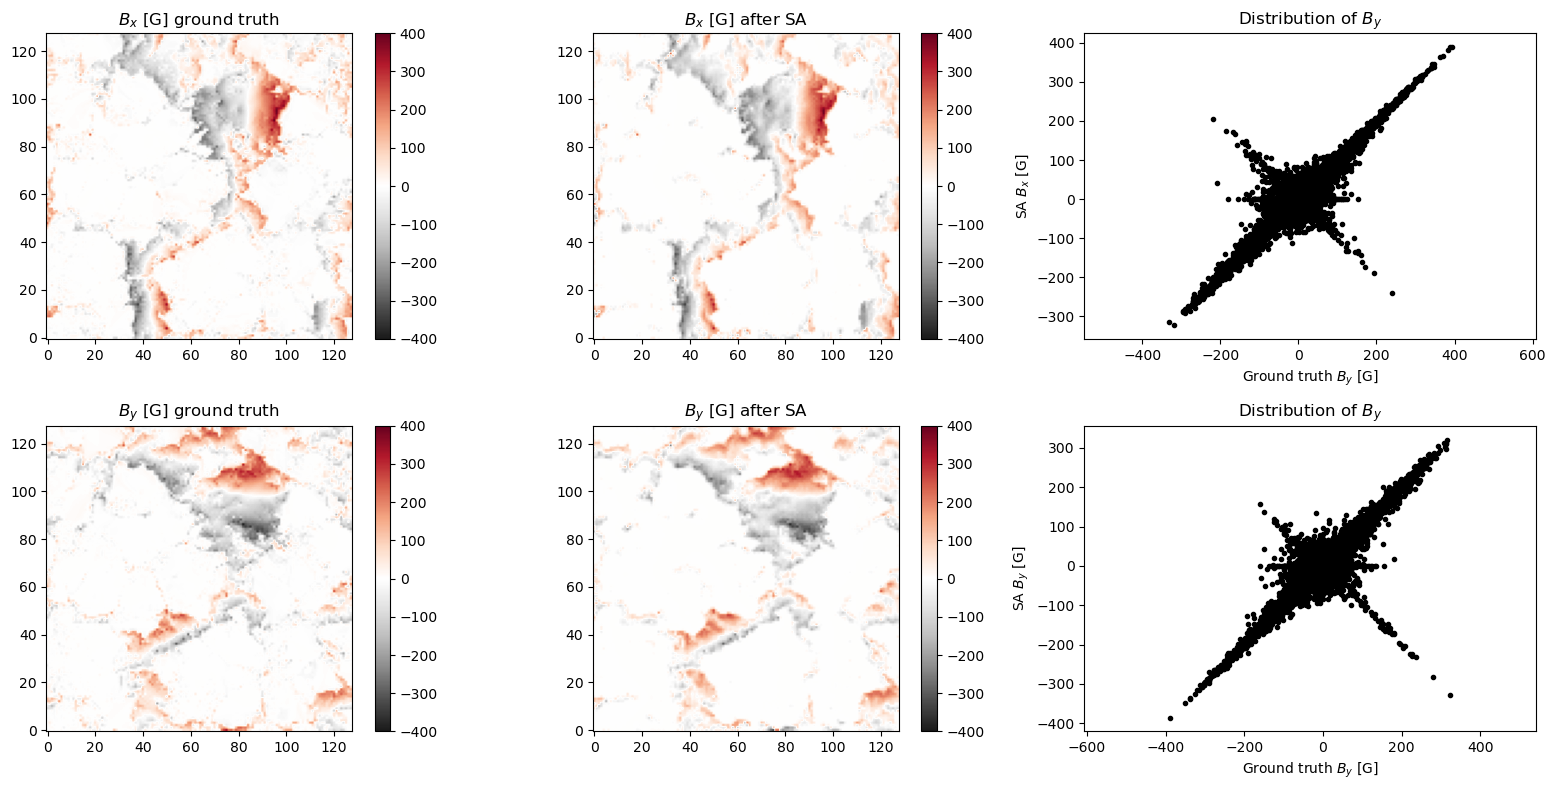

Bx correlation: 0.898, By correlation: 0.889


In [67]:
plt.figure(figsize=(16,8))
plt.subplot(231)
plt.imshow(Bx_true.T, origin='lower', cmap='RdGy_r', vmin=-400, vmax=400)
plt.title('$B_x$ [G] ground truth')
plt.colorbar()
plt.subplot(232)
plt.imshow(Bx_dis.T, origin='lower', cmap='RdGy_r', vmin=-400, vmax=400)
plt.colorbar()
plt.title('$B_x$ [G] after SA')
plt.subplot(233)
plt.plot(Bx_true.flatten(), Bx_pred.flatten(), 'k.')
plt.xlabel('Ground truth $B_y$ [G]')
plt.ylabel('SA $B_x$ [G]')
plt.axis('equal')
plt.title('Distribution of $B_y$')
plt.subplot(234)
plt.imshow(By_true.T, origin='lower', cmap='RdGy_r', vmin=-400, vmax=400)
plt.colorbar()
plt.title('$B_y$ [G] ground truth')
plt.subplot(235)
plt.imshow(By_dis.T, origin='lower', cmap='RdGy_r', vmin=-400, vmax=400)
plt.colorbar()
plt.title('$B_y$ [G] after SA')
plt.subplot(236)
plt.plot(By_true.flatten(), By_pred.flatten(), 'k.')
plt.xlabel('Ground truth $B_y$ [G]')
plt.ylabel('SA $B_y$ [G]')
plt.axis('equal')
plt.title('Distribution of $B_y$')
plt.tight_layout()
plt.show()

cc_Bx = np.corrcoef(Bx_dis.flatten(), Bx_true.flatten())[0,1]
cc_By = np.corrcoef(By_dis.flatten(), By_true.flatten())[0,1]

print(f"Bx correlation: {cc_Bx:.3f}, By correlation: {cc_By:.3f}")

In [62]:
Bx_pred = B_pred[0, 0, :, :].unsqueeze(0)  
By_pred = B_pred[0, 1, :, :].unsqueeze(0)  
Bz_pred = B_pred[0, 2, :, :].unsqueeze(0) 

I_obs_torch = stokes_torch[:, :, :, 0, :]  

V_synth = synthesize_stokes_V_wfa(Bz_pred, I_obs_torch, ll_tensor)
Q_synth, U_synth = synthesize_stokes_QU_wfa(Bx_pred, By_pred, I_obs_torch, ll_tensor, scale_factor=1e-8)

Bx_pred = Bx_pred[0].detach().cpu().numpy() 
By_pred = By_pred[0].detach().cpu().numpy()
Bz_pred = Bz_pred[0].detach().cpu().numpy()

V_pred = V_synth[0, :, :, :].detach().cpu().numpy()
Q_pred = Q_synth[0, :, :, :].detach().cpu().numpy()
U_pred = U_synth[0, :, :, :].detach().cpu().numpy()

V_obs = stokes_torch[0, :, :, 3, :].detach().cpu().numpy()
Q_obs = stokes_torch[0, :, :, 1, :].detach().cpu().numpy()
U_obs = stokes_torch[0, :, :, 2, :].detach().cpu().numpy()

print(f"\nGround truth Bx range: [{Bx_true.min():.1f}, {Bx_true.max():.1f}] G")
print(f"Ground truth By range: [{By_true.min():.1f}, {By_true.max():.1f}] G")
print(f"Ground truth Bz range: [{Bz_true.min():.1f}, {Bz_true.max():.1f}] G")

print(f"Final Bx range: [{Bx_pred.min():.1f}, {Bx_pred.max():.1f}] G")
print(f"Final By range: [{By_pred.min():.1f}, {By_pred.max():.1f}] G")
print(f"Final Bz range: [{Bz_pred.min():.1f}, {Bz_pred.max():.1f}] G")


Ground truth Bx range: [-332.3, 392.9] G
Ground truth By range: [-388.7, 323.7] G
Ground truth Bz range: [-160.6, 918.3] G
Final Bx range: [-322.5, 389.2] G
Final By range: [-385.5, 320.8] G
Final Bz range: [0.2, 849.6] G


In [63]:
cc_Bx = np.corrcoef(Bx_true.flatten(), Bx_pred.flatten())[0][1]
cc_By = np.corrcoef(By_true.flatten(), By_pred.flatten())[0][1]
cc_Bz = np.corrcoef(Bz_true.flatten(), Bz_pred.flatten())[0][1]
print(f"Bx correlation: {cc_Bx:.3f}, By correlation: {cc_By:.3f}, Bz correlation: {cc_Bz:.3f}")

cc_V = np.corrcoef(V_obs.flatten(), V_pred.flatten())[0][1]
cc_Q = np.corrcoef(Q_obs.flatten(), Q_pred.flatten())[0][1]
cc_U = np.corrcoef(U_obs.flatten(), U_pred.flatten())[0][1]
print(f"V correlation: {cc_V:.3f}, Q correlation: {cc_Q:.3f}, U correlation: {cc_U:.3f}")

Bt_pred = np.sqrt(Bx_pred**2 + By_pred**2)
Bt_true = np.sqrt(Bx_true**2 + By_true**2)

print(f"B transverse magnitude correlation: {np.corrcoef(Bt_pred.flat, Bt_true.flat)[0,1]:.3f}")

Bx correlation: 0.915, By correlation: 0.897, Bz correlation: 0.973
V correlation: 0.980, Q correlation: 0.984, U correlation: 0.984
B transverse magnitude correlation: 0.966


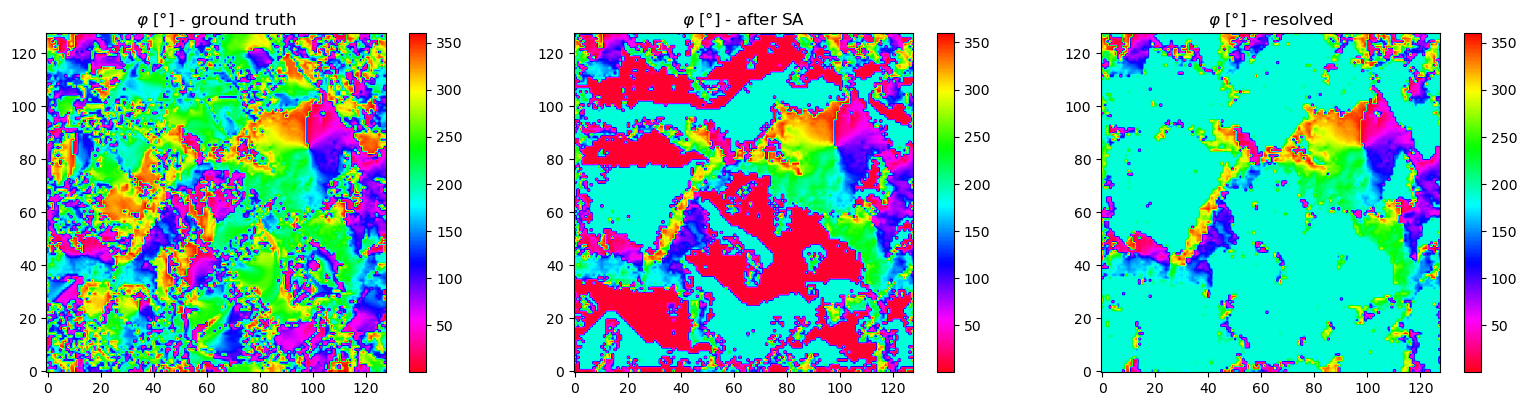

In [64]:
def azimuth(Bx, By):
    az = np.arctan2(By, Bx) * 180 / np.pi
    return az % 360

az_true = azimuth(Bx_true, By_true)
az_dis = azimuth(Bx_dis, By_dis)
az_pred = azimuth(Bx_pred, By_pred)

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.imshow(az_true, origin='lower', cmap='hsv_r')
plt.title(r'$\varphi$ [°] - ground truth')
plt.colorbar()
plt.subplot(132)
plt.imshow(az_dis, origin='lower', cmap='hsv_r')
plt.colorbar()
plt.title(r'$\varphi$ [°] - after SA')
plt.subplot(133)
plt.imshow(az_pred, origin='lower', cmap='hsv_r')
plt.colorbar()
plt.title(r'$\varphi$ [°] - resolved')
plt.tight_layout()
plt.show()

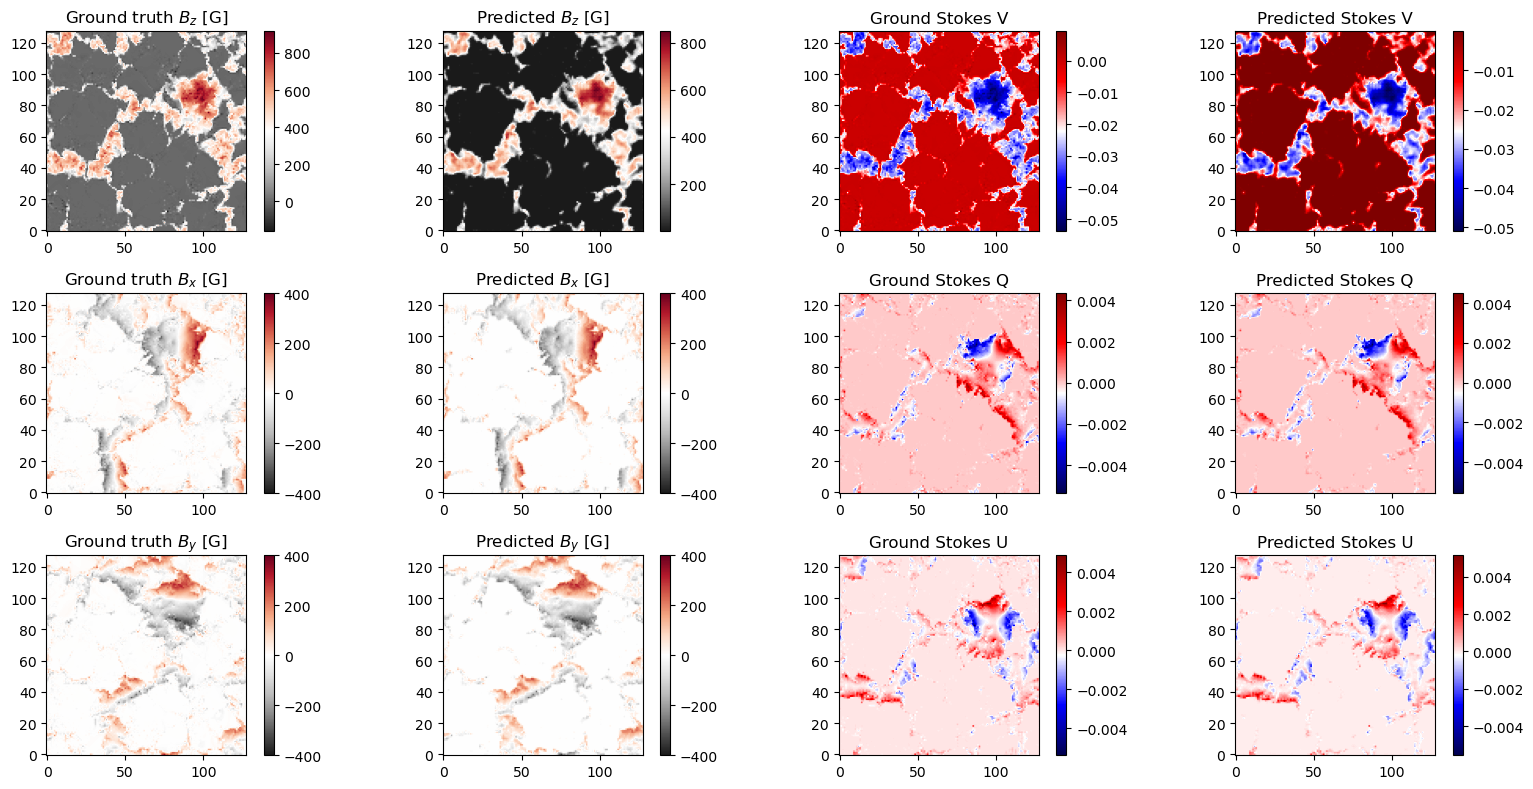

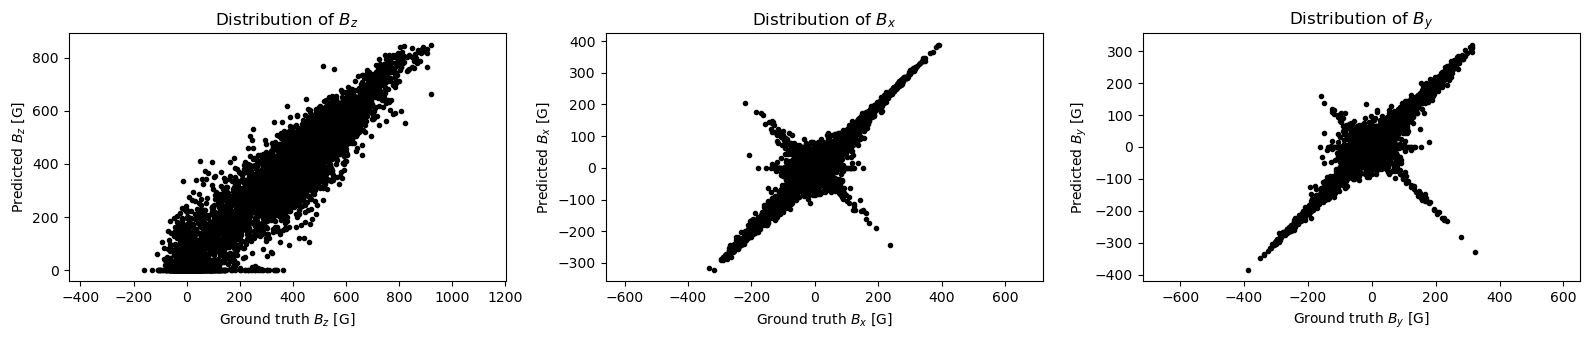

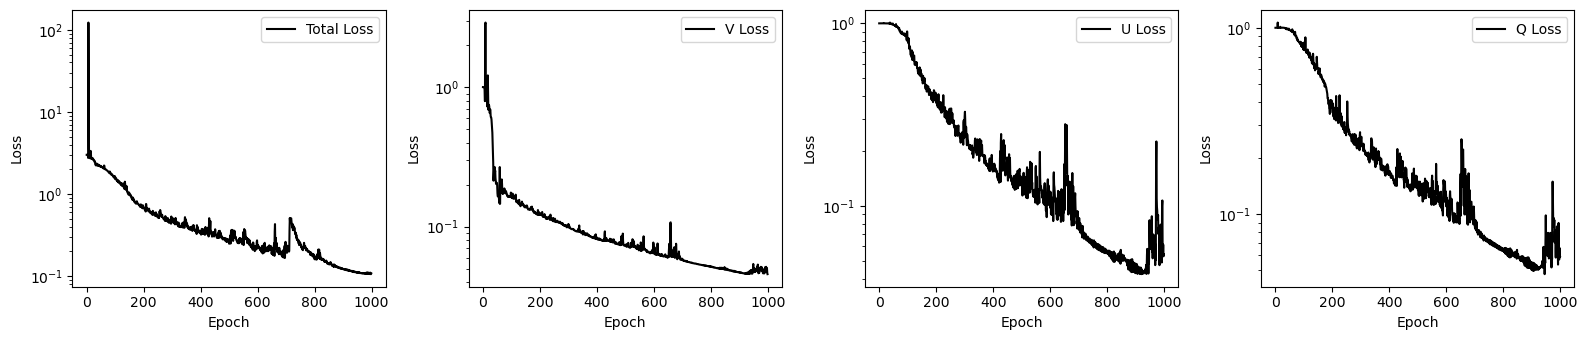

In [68]:
plt.figure(figsize=(16, 8))
plt.subplot(341)
plt.imshow(Bz_true, origin='lower', cmap='RdGy_r')
plt.colorbar()
plt.title(r'Ground truth $B_z$ [G]')
plt.subplot(342)
plt.imshow(Bz_pred, origin='lower', cmap='RdGy_r')
plt.colorbar()
plt.title(r'Predicted $B_z$ [G]')
plt.subplot(343)
plt.imshow(V_obs[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Ground Stokes V')
plt.subplot(344)
plt.imshow(V_pred[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Predicted Stokes V')
plt.subplot(345)
plt.imshow(Bx_true.T, origin='lower', cmap='RdGy_r', vmin=-400, vmax=400)
plt.colorbar()
plt.title(r'Ground truth $B_x$ [G]')
plt.subplot(346)
plt.imshow(Bx_pred.T, origin='lower', cmap='RdGy_r',vmin=-400, vmax=400)
plt.colorbar()
plt.title(r'Predicted $B_x$ [G]')
plt.subplot(347)
plt.imshow(Q_obs[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Ground Stokes Q')
plt.subplot(348)
plt.imshow(Q_pred[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Predicted Stokes Q')
plt.subplot(349)
plt.imshow(By_true.T, origin='lower', cmap='RdGy_r', vmin=-400, vmax=400)
plt.colorbar()
plt.title(r'Ground truth $B_y$ [G]')
plt.subplot(3,4,10)
plt.imshow(By_pred.T, origin='lower', cmap='RdGy_r', vmin=-400, vmax=400)
plt.colorbar()
plt.title(r'Predicted $B_y$ [G]')
plt.subplot(3,4,11)
plt.imshow(U_obs[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Ground Stokes U')
plt.subplot(3,4,12)
plt.imshow(U_pred[:,:,16], origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'Predicted Stokes U')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 3.5))
plt.subplot(131)
plt.plot(Bz_true.flatten(), Bz_pred.flatten(), 'k.')
plt.title('Distribution of $B_z$')
plt.xlabel('Ground truth $B_z$ [G]')
plt.ylabel('Predicted $B_z$ [G]')
plt.axis('equal')
plt.subplot(132)
plt.plot(Bx_true.flatten(), Bx_pred.flatten(), 'k.')
plt.title('Distribution of $B_x$')
plt.xlabel('Ground truth $B_x$ [G]')
plt.ylabel('Predicted $B_x$ [G]')
plt.axis('equal')
plt.subplot(133)
plt.plot(By_true.flatten(), By_pred.flatten(), 'k.')
plt.xlabel('Ground truth $B_y$ [G]')
plt.ylabel('Predicted $B_y$ [G]')
plt.axis('equal')
plt.title('Distribution of $B_y$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,3.5))
plt.subplot(141)
plt.semilogy(loss_history, label='Total Loss', color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(142)
plt.semilogy(loss_V_history, label='V Loss', color='black')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.legend()
plt.subplot(143)
plt.semilogy(loss_U_history, label='U Loss', color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(144)
plt.semilogy(loss_Q_history, label='Q Loss', color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

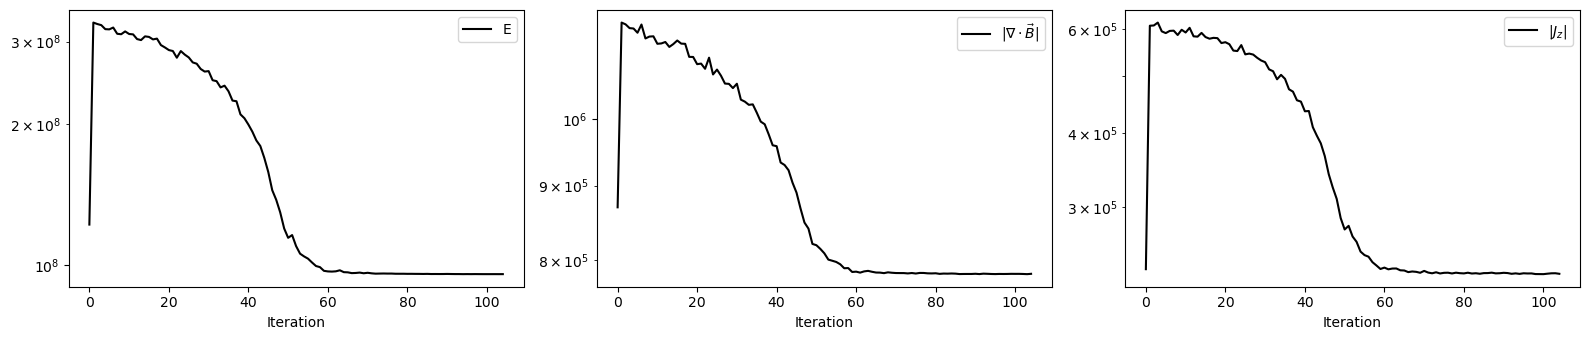

In [66]:
E, divB, jz = np.loadtxt('SA_behaviour.txt', unpack=True)
plt.figure(figsize=(16, 3.5))
plt.subplot(131)
plt.plot(E, label='E', color='black')
plt.yscale('log')
plt.xlabel('Iteration')
plt.legend()
plt.subplot(132)
plt.plot(divB, label=r'$|\nabla\cdot\vec{B}|$', color='black')
plt.yscale('log')
plt.xlabel('Iteration')
plt.legend()
plt.subplot(133)
plt.plot(jz, label=r'$|J_z|$', color='black')
plt.yscale('log')
plt.xlabel('Iteration')
plt.legend()
plt.tight_layout()
plt.show()